### Libraries

In [2]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image
import time

import numpy as np
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter, map_coordinates
from scipy.ndimage.interpolation import zoom
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader
import glob
from torchvision.transforms import ToPILImage
#!pip install git+https://github.com/facebookresearch/fvcore.git

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_2844506/3418150202.py:18: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom


In [1]:
pwd

'/home/shokoo/EchoView/video_class/notebooks'

In [3]:
original_address = '/home/shokoo/EchoView/video_class/'
# '/home/zahra.ghods/Data/dataset/'
# '/home/zahra.ghods'
# '/home/student/shokoofa/Downloads/dataset/'
# 'C:/echo/dataset
# '/scratch/student/shokoofa/'

In [4]:
paths = glob.glob(os.path.join(original_address + 'Dataset/**/*/*', '*')) #numebr of all samples per patients
len(paths)

6370

### Load the csv file containing the image file names and corresponding labels

In [5]:
info_train = pd.read_csv(os.path.join(original_address , 'files/video_model_labels/train_label_original.csv'))
info_val = pd.read_csv(os.path.join(original_address , 'files/video_model_labels/val_label_original.csv'))
info_test = pd.read_csv(os.path.join(original_address , 'files/video_model_labels/test_label_original.csv'))

In [6]:
len(info_train['label']), len(info_val['label']), len(info_test['label']), 

(4097, 506, 503)

In [7]:
info_train['path'][100], info_train['label'][100]

('Train/_9ecEo6FQYGXpjlFdZ64hw/26/2', 'PSAX-base')

### Preprocessing

### Define Transformers

In [8]:
class CustomCrop(object):
    """Crops the bottom 1/10 of the height and 1/8 of the width of the image."""
    def __call__(self, img):
        w, h = img.size
        new_h = h - h // 15
        top = 0
        left = w // 10
        return img.crop((left, top, w, new_h))
    
class AddGaussianNoise:
    """Add Gaussian noise to a video."""
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    

to_pil = ToPILImage()
    

all_data_transform = transforms.Compose([
    CustomCrop(),
#     transforms.Resize((224, 224)), #resNext50
    # transforms.Resize((256, 256)), #efficientNet-b0
    transforms.Resize((288, 288)), #efficientNet-b2
    # transforms.Resize((299, 299)), # JUST FOR INCEPTION
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # Lambda(lambda x: x/255),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    # AddNormalization()
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),  # Horizontal flip
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=10),  # Small rotation
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.2),  # Brightness & contrast
    transforms.ToTensor(),
    transforms.RandomApply([AddGaussianNoise(0., 0.1)], p=0.2),
    
])


### Map images to their labels

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, transform, training_transform = None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.training_transform = training_transform
        self.valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }

    def __len__(self):
        return len(self.paths)

    def preprocessing(self, image_array, label, k = 100):
        slices, ch, height, width = image_array.shape

        mask = torch.zeros((ch, height, width), dtype=torch.uint8)
        steps = min(k, slices)
        for i in range(steps - 1):
            mask[image_array[i, :, :, :] != image_array[i + 1, :, :, :]] = 1
        output = image_array * mask
        # visualization(mask[0], label)
        return output

    def address(self,index):
        return original_address + 'Dataset/' + self.paths[index]
    
                
    def __getitem__(self, index):
        # start = time.time()
        # Get the filename and label for the current index
        filepath = original_address + 'Dataset/' + self.paths[index]
        label = self.labels[index]
        label = torch.tensor([self.valid_labels[str(label)]])


        # sort the image in based on the order of the slices saved in the folder
        addresses = glob.glob(os.path.join(filepath, '*'))


        images_list = []
        for img_path in addresses[:10]:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            images_list.append(image)
            
        sequence_tensor = torch.stack(images_list)
        preprocessed_sequence = self.preprocessing(sequence_tensor, label)

#         image = preprocessed_sequence[int(len(preprocessed_sequence)//2)]

        # R_peak frame 
        image = preprocessed_sequence[0]

        if self.training_transform is not None:
            image = self.training_transform(to_pil(image))
        
        image = torch.stack([image])
        # print(f"Load time: {time.time() - start:.4f}s")
        return image, label

In [10]:
def visualization(image, label):
  plt.figure(figsize= (10,8))
  # im = Image.fromarray(image.permute(1,2,0))
  # plt.imshow(image.permute(1,2,0))
  plt.imshow(image, cmap= 'gray')
  plt.title(label.item())
  plt.xticks([])
  plt.yticks([])
  plt.show()

### Load the train dataset from the folder

In [11]:
train_data = CustomDataset(info_train['path'], info_train['label'], transform=all_data_transform, training_transform=train_transform)
val_data = CustomDataset(info_val['path'], info_val['label'], transform=all_data_transform)
test_data = CustomDataset(info_test['path'], info_test['label'], transform=all_data_transform)

In [12]:
test_data.address(10)

'/home/shokoo/EchoView/video_class/Dataset/Test/_497VMYVSZywku-h2UmnUw/22/0'

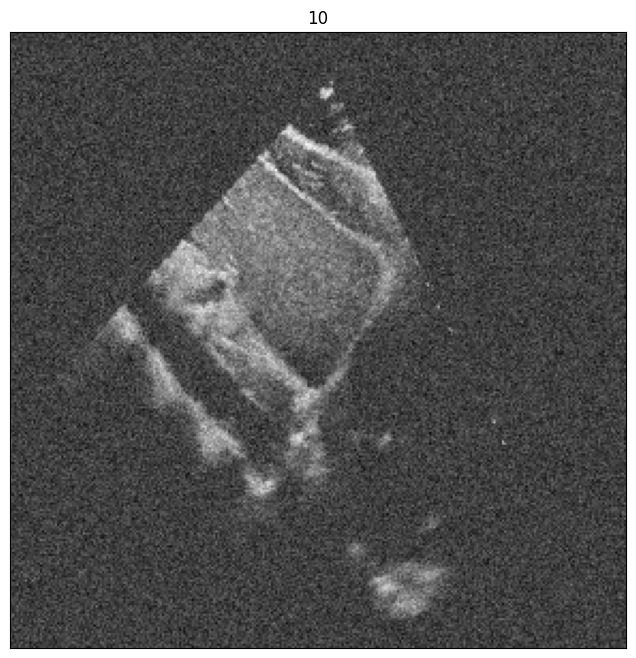

tensor(1.2143)

In [13]:
visualization(train_data[4][0][0][0],train_data[1][1] )
train_data[87][0][0].max()

### Create data loaders for the train and validation sets



In [14]:
train_loader = DataLoader(train_data, batch_size=32, drop_last=True, shuffle=True, pin_memory=True, num_workers= 4, persistent_workers=True)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 4, persistent_workers=True)
# collate_fn=collate_fn)
# #pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 4, persistent_workers=True)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [15]:
for i,l in train_loader:
    print(i.shape)
    break

torch.Size([32, 1, 3, 288, 288])


### Define the neural network model architecture

In [18]:
class CNNLSTM(nn.Module):
    def __init__(self, in_channels, cnn_output_size, num_classes):
        super(CNNLSTM, self).__init__()
        self.num_classes = num_classes
        self.cnn_output_size = cnn_output_size

        # self.conv = torchvision.models.resnet18(pretrained = False)
        self.conv = torchvision.models.efficientnet_b2(pretrained=True)
#         self.conv = torchvision.models.resnext50_32x4d(pretrained = 'True')
#         self.conv = torchvision.models.googlenet(pretrained=False,dropout = 0.3)

        # self.conv = torchvision.models.inception_v3(weights='DEFAULT')

        self.classifier_layer = nn.Sequential( nn.Linear(self.cnn_output_size, num_classes))

    def forward(self, x):
        batch_size, frame1 , C, H, W = x.size()
        x = x.view(batch_size*frame1, C, H, W)
        c_out = self.conv(x)
#         c_out = c_out[0] #just google net
        output = self.classifier_layer(c_out)
        return output

cnn_output_size = 1000
model = CNNLSTM(3,cnn_output_size, 11)

In [17]:
class SEBlock(nn.Module):
    """
    Squeeze Excitation Block
    """
    def __init__(self, input_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(input_channels, input_channels // reduction, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_channels // reduction, input_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Forward Pass
        """
        batch_size, channels, _, _ = x.size()
        y = self.global_avg_pool(x).view(batch_size, channels)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch_size, channels, 1, 1)
        return x * y

class CNNLSTM(nn.Module):
    """
    Image CNN LSTM Model
    """
    def __init__(self):
        super(CNNLSTM, self).__init__()

        # Load EfficientNet B2 without the final classification layer
        self.conv = torchvision.models.efficientnet_b2(pretrained=True).features

        # EfficientNet B2 output feature map has 1408 channels
        cnn_output_channels = 1408

        # SE block after EfficientNet
        self.se_block = SEBlock(input_channels=cnn_output_channels)

        # Classifier layer
        self.classifier_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Pool to (1,1) size
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(cnn_output_channels, 11)
        )

    def forward(self, x):
        """
        Forward pass
        """
        _batch_size, _frame1, _c, _h, _w = x.size()
        x = x.view(_batch_size * _frame1, _c, _h, _w)
        c_out = self.conv(x)
        c_out = self.se_block(c_out)  # Apply SE block
        output = self.classifier_layer(c_out)
        return output, torch.softmax(output, dim = 1)
    
model = CNNLSTM()

In [ ]:
input1 = torch.rand(8, 3, 256, 256)
# input2 = torch.rand(8, 10, 3, 299, 299)
# model.eval()
print(model(input1))
# print(model(input2))

### Define loss and optimizer

In [21]:
torch.cuda.is_available()
# !export CUDA_VISIBLE_DEVICES=0

True

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(device)

cuda


#### Load a Pretrained Model

In [149]:
state_dict = torch.load('/home/shokoo/EchoView/video_class/singleframe/test3.pth', map_location='cpu')
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model.to(device)

CNNLSTM(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
    

### Train the model

In [150]:
val_acc, val_loss = evaluate(model, val_loader, device, mode='valid')

valid epoch 0: Loss(1.9141),  Accuracy (0.6271))


In [25]:
def evaluate(model, loader, device, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total += images.size(0)
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
      total_loss += loss.item() * images.size(0)
      # print('Valid \t',  predictions, labels, labels == predictions, total_correct, total, images.size(0), '\n')

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss



In [26]:
# model = model.to(device)
epochs = 20
# BATCH_SIZE = 64
accs = []
losses = []
val_loss = 0.0
best_val_loss = float('inf')
for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects = 0
  # epochs_no_improve = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    labels = labels.squeeze(1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total += images.size(0)
    _, predictions = outputs.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects += (predictions == labels).sum()
    # print('TRAIN:', predictions, labels,  running_corrects, '\n')
    # total_loss += loss.item() * images.size(0)
    
  # accuracy = total_correct / total

  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  accs.append(epoch_acc)
  losses.append(epoch_loss)
  # loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy ({epoch_acc:6.5f}) )')
  val_acc, val_loss = evaluate(model, val_loader, device, mode='valid')
  accs.append(val_acc)
  losses.append(val_loss)

  print('---')

  if(val_loss < best_val_loss):
    best_acc = val_acc
    best_val_loss = val_loss
    epochs_no_improve = 0
#     torch.save(model.state_dict(), (f'/home/student/shokoofa/Downloads/res_model{epoch}.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve > 5 and epoch > 7:
    print('no further improvement ', best_acc)
    break


Train epoch 0: Loss(1.4781, Accuracy (0.51001) )
valid epoch 0: Loss(1.5441),  Accuracy (0.5396))
---
Train epoch 1: Loss(0.8896, Accuracy (0.69629) )
valid epoch 1: Loss(0.7480),  Accuracy (0.7354))
---
Train epoch 2: Loss(0.6803, Accuracy (0.77271) )
valid epoch 2: Loss(0.5905),  Accuracy (0.8000))
---
Train epoch 3: Loss(0.5625, Accuracy (0.81128) )
valid epoch 3: Loss(0.6490),  Accuracy (0.7979))
---
Train epoch 4: Loss(0.5233, Accuracy (0.82031) )
valid epoch 4: Loss(0.6608),  Accuracy (0.7729))
---
Train epoch 5: Loss(0.4256, Accuracy (0.85913) )
valid epoch 5: Loss(0.7244),  Accuracy (0.7771))
---
Train epoch 6: Loss(0.3928, Accuracy (0.86670) )
valid epoch 6: Loss(0.6155),  Accuracy (0.8188))
---
Train epoch 7: Loss(0.3661, Accuracy (0.87695) )
valid epoch 7: Loss(0.5790),  Accuracy (0.8292))
---
Train epoch 8: Loss(0.3290, Accuracy (0.89038) )
valid epoch 8: Loss(0.8249),  Accuracy (0.7604))
---
Train epoch 9: Loss(0.2830, Accuracy (0.90723) )
valid epoch 9: Loss(1.3691),  Acc

KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), (f'/home/shokoo/EchoView/video_class/singleframe/efficientNet_model.pth'))

In [28]:
def evaluate(model, loader, device, mode='Test'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0) 
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss

evaluate(model, loader= test_loader, device = device)


Test Loss(0.6415),  Accuracy (0.8375))


(tensor(0.8375, device='cuda:0'), 0.6414989188313485)

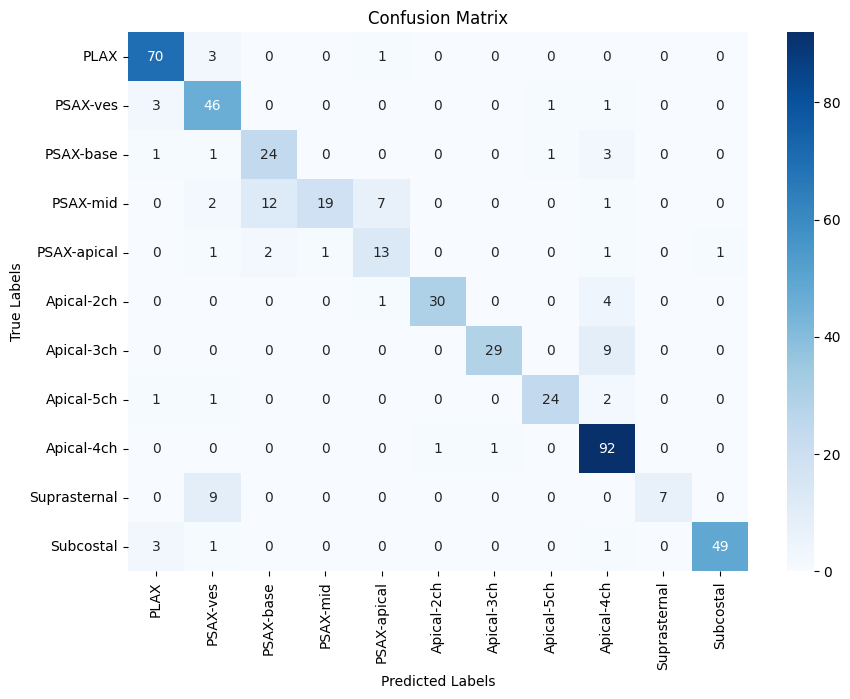

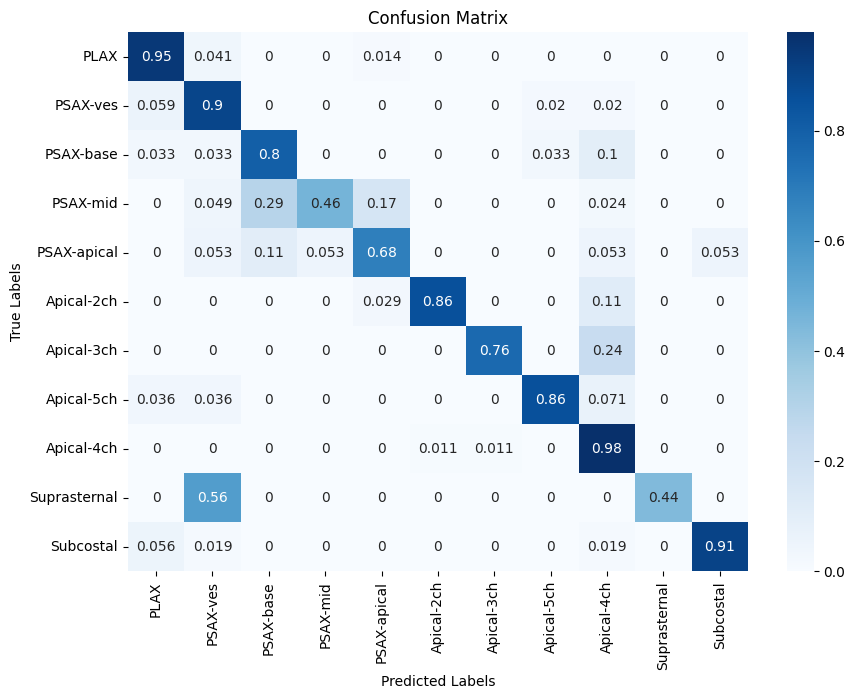

In [114]:
true_labels, pred_labels = [], []

valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
model.eval()
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    
    with torch.no_grad():
        outputs = model(images)
        _, predictions = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

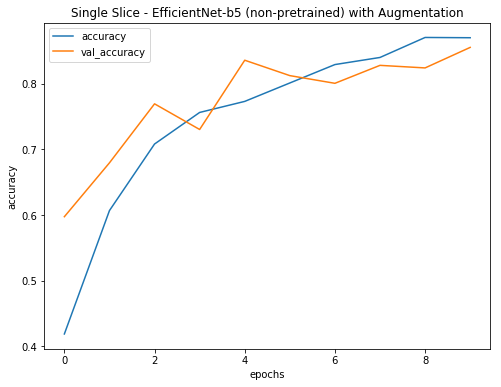

In [ ]:
from numpy.core.multiarray import zeros
import matplotlib.pyplot as plt
import numpy as np


# Generate sample data
x = [i for i in range(0,len(accs)//2)]
y = [accs[i].cpu() for i in range(0,len(accs),2)]
z = [accs[i].cpu() for i in range(1,len(accs),2)]


# Create a new figure and set the size
fig = plt.figure(figsize=(8, 6))

# Add a new subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the line graph
ax.plot(x, y, label='accuracy')
ax.plot(x, z, label='val_accuracy')
ax.legend()
# Set the title and axis labels
ax.set_title('Single Slice - EfficientNet-b5 (non-pretrained) with Augmentation')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

# Display the plot
plt.show()


In [ ]:
# predictions == labels